In [4]:
from massspecgym.data.datasets import MSnDataset, MassSpecDataset
from massspecgym.data.transforms import MolFingerprinter, SpecTokenizer
from massspecgym.data import MassSpecDataModule
from massspecgym.featurize import SpectrumFeaturizer

In [5]:
file_mgf = "/Users/macbook/CODE/Majer:MassSpecGym/data/MSn/20241211_msn_library_pos_all_lib_MSn.mgf"
split_file = "/Users/macbook/CODE/Majer:MassSpecGym/data/MSn/20241211_split.tsv"

In [14]:
config = {
    'features': ['binned_peaks'],
    'feature_attributes': {
        'binned_peaks': {
            'max_mz': 1005,
            'bin_width': 1.0,
        },
    },
}

In [15]:
featurizer = SpectrumFeaturizer(config, mode='torch')

In [16]:
# Init hyperparameters
n_peaks = 60
fp_size = 4096
batch_size = 12

msn_dataset = MSnDataset(
    pth=file_mgf,
    featurizer=featurizer,
    mol_transform=MolFingerprinter(fp_size=fp_size),
    max_allowed_deviation=0.005
)

In [17]:
msn_dataset[0]

{'spec': Data(x=[14, 1005], edge_index=[2, 13]),
 'mol': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 'precursor_mz': tensor(347.1489),
 'adduct': '[M+H]+',
 'identifier': '0000002_0000000',
 'mol_freq': tensor(1.)}

In [18]:
len(msn_dataset)

16476

In [19]:
len(msn_dataset.trees)

16476

In [20]:
msn_dataset.trees[0]

347.14891
  329.139404296875
    175.075592041016
    160.051956176758
  193.086303710938
    151.075317382813
    107.049133300781
  175.076354980469
  155.070388793945
    112.051902770996
    95.049163818359
  151.075546264648
    135.044143676758
    107.049140930176

## Node similarities

In [21]:
import random
import numpy as np
import torch
from typing import List, Dict, Tuple, Optional
from matchms import Spectrum

In [23]:
import random
import numpy as np
import torch
from typing import List, Dict, Tuple, Optional
from matchms import Spectrum

############################################################
## 1) Classical Cosine Similarity (Spectrum-based)
############################################################

def classical_cosine_similarity(specA: Spectrum, specB: Spectrum) -> float:
    """
    Computes a simple vector-based cosine similarity between
    two matchms.Spectrum objects, using binned intensities
    or any other vector representation you define.

    NOTE: This example uses a naive approach:
      1) Extract the 'mz' and 'intensity' arrays from each spectrum
      2) Create a shared binned representation (like 0.1 Da bins) or a dictionary-based
         representation for the intensities
      3) Compute the dot-product / norm-based cosine.

    For a more robust approach, consider matchms functions or MS2DeepScore, etc.
    """
    if specA is None or specB is None:
        return np.nan  # or 0.0
    mzA, intA = specA.peaks.mz, specA.peaks.intensities
    mzB, intB = specB.peaks.mz, specB.peaks.intensities

    # Example approach: convert to a dictionary {mz_rounded: intensity}
    # then unify keys and compute dot product.
    # (More advanced binning or tolerance is recommended in practice.)
    dictA = {round(m, 2): i for m, i in zip(mzA, intA)}
    dictB = {round(m, 2): i for m, i in zip(mzB, intB)}

    common_mzs = set(dictA.keys()).intersection(set(dictB.keys()))
    dotprod = sum([dictA[m]*dictB[m] for m in common_mzs])

    normA = np.sqrt(sum(val*val for val in dictA.values()))
    normB = np.sqrt(sum(val*val for val in dictB.values()))
    if normA == 0.0 or normB == 0.0:
        return 0.0

    cos = dotprod / (normA * normB)
    return cos


############################################################
## 2) DreaMS Embedding Similarity (vector-based)
############################################################

def dreams_embedding_similarity(embeddingA: torch.Tensor,
                               embeddingB: torch.Tensor,
                               sim_type: str = "cosine") -> float:
    """
    If you have a precomputed DreaMS (or other model) embedding for each node,
    compute the similarity (e.g. cosine). Assumes each embedding is a 1D torch.Tensor.
    """
    if embeddingA is None or embeddingB is None:
        return float('nan')

    if sim_type == "cosine":
        # Dot-product normalized
        dot = torch.dot(embeddingA, embeddingB).item()
        normA = torch.norm(embeddingA).item()
        normB = torch.norm(embeddingB).item()
        if normA == 0.0 or normB == 0.0:
            return 0.0
        return float(dot / (normA*normB))
    else:
        raise ValueError(f"Unknown sim_type: {sim_type}")


############################################################
## 3) Gathering Node Embeddings or Spectra
############################################################

def get_node_spectrum(node) -> Optional[Spectrum]:
    """
    A small helper that returns the matchms.Spectrum from a TreeNode.
    node.spectrum is likely already a Spectrum object.
    """
    return node.spectrum

def get_node_embedding(node, embed_dict=None) -> Optional[torch.Tensor]:
    """
    If you have a dictionary of precomputed embeddings for each node identifier,
    this function looks them up. Alternatively, you might call some model directly.

    node.spectrum.get('identifier') is the unique ID.
    """
    if node.spectrum is None:
        return None
    node_id = node.spectrum.get('identifier')
    if embed_dict is None:
        return None
    return embed_dict.get(node_id, None)


############################################################
## 4) Relationship-based Similarity Computations
##
##   These are the main analyses for:
##   (a) ancestor-descendant
##   (b) siblings, grandparents/cousins
##   (c) chimeric or cross-branch merges
############################################################

def compute_ancestor_descendant_similarity(tree,
                                           use_embedding: bool = False,
                                           embed_dict=None,
                                           sim_fn=None) -> List[float]:
    """
    For each node in the tree (except the root), compute similarity to its parent.
    Return the list of all parent-child similarities.

    If use_embedding is True, we fetch the node embeddings from embed_dict
    (embeddingA, embeddingB). Then we pass them to dreams_embedding_similarity
    or a custom `sim_fn`.

    If use_embedding is False, we do classical spectral-based similarity
    with `classical_cosine_similarity` or your chosen function.
    """
    similarities = []

    # BFS over the tree
    from collections import deque
    queue = deque([tree.root])
    while queue:
        parent_node = queue.popleft()
        for child_node in parent_node.children.values():
            # Compute similarity parent vs. child
            if use_embedding:
                if sim_fn is None:
                    sim_fn = dreams_embedding_similarity
                embA = get_node_embedding(parent_node, embed_dict=embed_dict)
                embB = get_node_embedding(child_node, embed_dict=embed_dict)
                sim = sim_fn(embA, embB) if (embA is not None and embB is not None) else float('nan')
            else:
                if sim_fn is None:
                    sim_fn = classical_cosine_similarity
                specA = get_node_spectrum(parent_node)
                specB = get_node_spectrum(child_node)
                sim = sim_fn(specA, specB)

            similarities.append(sim)
            queue.append(child_node)

    return similarities


def compute_sibling_similarity(tree,
                               use_embedding: bool = False,
                               embed_dict=None,
                               sim_fn=None) -> List[float]:
    """
    For each parent, get all children. Compute pairwise similarities
    among these siblings, collect them all, and return as a list.
    """
    sib_sims = []

    from collections import deque
    queue = deque([tree.root])
    while queue:
        parent_node = queue.popleft()
        child_values = list(parent_node.children.values())
        # All pairwise among siblings
        for i in range(len(child_values)):
            for j in range(i+1, len(child_values)):
                nodeA = child_values[i]
                nodeB = child_values[j]
                if use_embedding:
                    if sim_fn is None:
                        sim_fn = dreams_embedding_similarity
                    embA = get_node_embedding(nodeA, embed_dict=embed_dict)
                    embB = get_node_embedding(nodeB, embed_dict=embed_dict)
                    sim = sim_fn(embA, embB) if (embA is not None and embB is not None) else float('nan')
                else:
                    if sim_fn is None:
                        sim_fn = classical_cosine_similarity
                    specA = get_node_spectrum(nodeA)
                    specB = get_node_spectrum(nodeB)
                    sim = sim_fn(specA, specB)
                sib_sims.append(sim)

        # Continue BFS
        for child_node in parent_node.children.values():
            queue.append(child_node)

    return sib_sims


def detect_chimeric_branches(tree,
                             use_embedding: bool = False,
                             embed_dict=None,
                             sim_fn=None) -> Dict[str, bool]:
    """
    For each node, compare similarity to:
       - its parent
       - all other nodes in the tree
    Then check if there's a different node (in a different branch) that has
    significantly higher similarity than the parent's similarity -> might indicate
    "chimeric" or misassigned fragmentation path.

    Return a dictionary node_id -> True/False indicating if that node is "chimeric".
    """
    # 1) Gather all nodes
    from collections import deque
    all_nodes = []
    queue = deque([tree.root])
    while queue:
        n = queue.popleft()
        all_nodes.append(n)
        for c in n.children.values():
            queue.append(c)

    # 2) For each node, compute similarity to parent vs. to others
    if sim_fn is None:
        sim_fn = dreams_embedding_similarity if use_embedding else classical_cosine_similarity

    node_is_chimeric = {}
    for node in all_nodes:
        if node is tree.root or node.spectrum is None:
            node_is_chimeric[node.spectrum.get('identifier', 'root')] = False
            continue
        # get parent's similarity
        parent = _find_parent_of_node(tree.root, node)
        if parent is None:
            node_is_chimeric[node.spectrum.get('identifier','???')] = False
            continue

        # node's parent-child sim
        sim_parent = _compute_node_to_node_similarity(node, parent,
                                                      use_embedding, embed_dict, sim_fn)

        # node's best sim to any other node except itself or parent
        best_sim = -1.0
        best_sim_node = None
        for n2 in all_nodes:
            if n2 is node or n2 is parent: 
                continue
            sim_candidate = _compute_node_to_node_similarity(node, n2,
                                                             use_embedding, embed_dict, sim_fn)
            if sim_candidate > best_sim:
                best_sim = sim_candidate
                best_sim_node = n2

        # If the best_sim is significantly greater than sim_parent,
        # we might call it chimeric. You can define a threshold or margin.
        # Example: if best_sim is 0.2 higher than sim_parent => chimeric
        margin = 0.2
        if best_sim - sim_parent > margin:
            # Potentially chimeric
            node_id = node.spectrum.get('identifier','???')
            node_is_chimeric[node_id] = True
        else:
            node_id = node.spectrum.get('identifier','???')
            node_is_chimeric[node_id] = False

    return node_is_chimeric


def _find_parent_of_node(root_node, target_node):
    """
    BFS or DFS to find parent of target_node starting from root_node.
    Return the parent node or None if not found or if target_node is root.
    """
    from collections import deque
    queue = deque([root_node])
    while queue:
        current = queue.popleft()
        for child in current.children.values():
            if child is target_node:
                return current
            queue.append(child)
    return None


def _compute_node_to_node_similarity(nodeA, nodeB,
                                     use_embedding: bool,
                                     embed_dict=None,
                                     sim_fn=None) -> float:
    """Helper to compute similarity between any two nodes, 
       either embeddings or classical spectral cosine."""
    if sim_fn is None:
        sim_fn = dreams_embedding_similarity if use_embedding else classical_cosine_similarity
    if use_embedding:
        embA = get_node_embedding(nodeA, embed_dict)
        embB = get_node_embedding(nodeB, embed_dict)
        if embA is None or embB is None:
            return float('nan')
        return sim_fn(embA, embB)
    else:
        specA = get_node_spectrum(nodeA)
        specB = get_node_spectrum(nodeB)
        return sim_fn(specA, specB)


############################################################
## 5) Global or Random Pair Comparisons
############################################################

def random_node_pairs(dataset,
                      num_pairs: int = 1000,
                      use_embedding: bool = False,
                      embed_dict=None,
                      sim_fn=None) -> List[float]:
    """
    For a dataset of multiple trees, sample random pairs of nodes 
    from any tree in the dataset. This helps build a baseline distribution 
    of "unrelated" or random pairs.

    Return a list of similarities.
    """
    # Gather all nodes from all trees
    all_nodes = []
    for tree in dataset.trees:
        # BFS
        from collections import deque
        queue = deque([tree.root])
        while queue:
            n = queue.popleft()
            all_nodes.append(n)
            for c in n.children.values():
                queue.append(c)

    if len(all_nodes) < 2:
        return []

    all_sims = []
    if sim_fn is None:
        sim_fn = dreams_embedding_similarity if use_embedding else classical_cosine_similarity

    # Sample random pairs
    for _ in range(num_pairs):
        nodeA = random.choice(all_nodes)
        nodeB = random.choice(all_nodes)
        if nodeA is nodeB:
            # skip if same node
            continue
        sim = _compute_node_to_node_similarity(nodeA, nodeB,
                                               use_embedding, embed_dict, sim_fn)
        all_sims.append(sim)

    return all_sims


############################################################
## 6) Summaries / Plots
############################################################

def summarize_similarity_distribution(sim_values: List[float]) -> dict:
    """
    Given a list of similarity values, compute summary stats (mean, std, median).
    Return as a dict. You can expand with quartiles, etc.
    """
    array = np.array(sim_values)
    array = array[~np.isnan(array)]  # remove NaNs
    if len(array) == 0:
        return {"mean": np.nan, "std": np.nan, "median": np.nan, "count": 0}
    return {
        "mean": float(np.mean(array)),
        "std": float(np.std(array)),
        "median": float(np.median(array)),
        "count": len(array)
    }

In [24]:
import numpy as np
import matplotlib.pyplot as plt

Ancestor-Descendant similarity stats: {'mean': 0.3699364625527902, 'std': 0.2835879364185114, 'median': 0.3002427253177061, 'count': 166808}
Sibling similarity stats: {'mean': 0.23387913655790224, 'std': 0.2927818910121449, 'median': 0.0919686032629337, 'count': 173661}
Random pairs similarity stats: {'mean': 0.01660495204884054, 'std': 0.07000186369712876, 'median': 0.0, 'count': 150000}


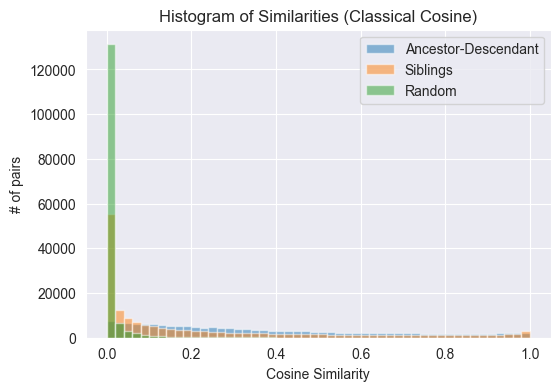

Chimeric detection for tree0: {'0000002_0000000': False, '0000008_0000001': True, '0000008_0000010': False, '0000008_0000028': True, '0000008_0000030': False, '0000008_0000045': True, '0000008_0000005': True, '0000008_0000007': True, '0000008_0000017': True, '0000008_0000024': True, '0000008_0000037': False, '0000008_0000041': True, '0000008_0000052': False, '0000008_0000059': True}


In [27]:
ad_sims = []
for tree in msn_dataset.trees:
    sims = compute_ancestor_descendant_similarity(tree,
                                                  use_embedding=False,
                                                  sim_fn=None)  # default classical cosine
    ad_sims.extend(sims)

stats_ad = summarize_similarity_distribution(ad_sims)
print("Ancestor-Descendant similarity stats:", stats_ad)

# Example 2: Sibling Similarities (Using classical cosine)
sib_sims = []
for tree in msn_dataset.trees:
    sims = compute_sibling_similarity(tree, use_embedding=False)
    sib_sims.extend(sims)

stats_sib = summarize_similarity_distribution(sib_sims)
print("Sibling similarity stats:", stats_sib)

# Example 3: Compare with random pairs
rand_sims = random_node_pairs(msn_dataset, num_pairs=15000)
stats_rand = summarize_similarity_distribution(rand_sims)
print("Random pairs similarity stats:", stats_rand)

# Plot distributions
plt.figure(figsize=(6,4))
plt.hist(ad_sims, bins=50, alpha=0.5, label='Ancestor-Descendant')
plt.hist(sib_sims, bins=50, alpha=0.5, label='Siblings')
plt.hist(rand_sims, bins=50, alpha=0.5, label='Random')
plt.xlabel("Cosine Similarity")
plt.ylabel("# of pairs")
plt.legend()
plt.title("Histogram of Similarities (Classical Cosine)")
plt.show()

# Example 4: Detect possible chimeric nodes in one particular tree
tree0 = msn_dataset.trees[0]
chimeric_dict = detect_chimeric_branches(tree0, use_embedding=False)
print("Chimeric detection for tree0:", chimeric_dict)

Ancestor-Descendant similarity stats: {'mean': 0.3699364625527902, 'std': 0.2835879364185114, 'median': 0.3002427253177061, 'count': 166808}
Sibling similarity stats: {'mean': 0.23387913655790224, 'std': 0.2927818910121449, 'median': 0.0919686032629337, 'count': 173661}
Random pairs similarity stats: {'mean': 0.016621280594866714, 'std': 0.07010088590509665, 'median': 0.0, 'count': 150000}


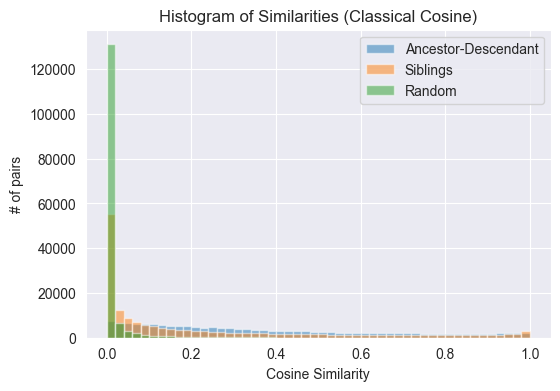

Chimeric detection for tree0: {'0000002_0000000': False, '0000008_0000001': True, '0000008_0000010': False, '0000008_0000028': True, '0000008_0000030': False, '0000008_0000045': True, '0000008_0000005': True, '0000008_0000007': True, '0000008_0000017': True, '0000008_0000024': True, '0000008_0000037': False, '0000008_0000041': True, '0000008_0000052': False, '0000008_0000059': True}


In [28]:
ad_sims = []
for tree in msn_dataset.trees:
    sims = compute_ancestor_descendant_similarity(tree,
                                                  use_embedding=False,
                                                  sim_fn=None)  # default classical cosine
    ad_sims.extend(sims)

stats_ad = summarize_similarity_distribution(ad_sims)
print("Ancestor-Descendant similarity stats:", stats_ad)

# Example 2: Sibling Similarities (Using classical cosine)
sib_sims = []
for tree in msn_dataset.trees:
    sims = compute_sibling_similarity(tree, use_embedding=False)
    sib_sims.extend(sims)

stats_sib = summarize_similarity_distribution(sib_sims)
print("Sibling similarity stats:", stats_sib)

# Example 3: Compare with random pairs
rand_sims = random_node_pairs(msn_dataset, num_pairs=15000)
stats_rand = summarize_similarity_distribution(rand_sims)
print("Random pairs similarity stats:", stats_rand)

# Plot distributions
plt.figure(figsize=(6,4))
plt.hist(ad_sims, bins=50, alpha=0.5, label='Ancestor-Descendant')
plt.hist(sib_sims, bins=50, alpha=0.5, label='Siblings')
plt.hist(rand_sims, bins=50, alpha=0.5, label='Random')
plt.xlabel("Cosine Similarity")
plt.ylabel("# of pairs")
plt.legend()
plt.title("Histogram of Similarities (Classical Cosine)")
plt.show()

# Example 4: Detect possible chimeric nodes in one particular tree
tree0 = msn_dataset.trees[0]
chimeric_dict = detect_chimeric_branches(tree0, use_embedding=False)
print("Chimeric detection for tree0:", chimeric_dict)